# Generalized Method of Moments with ARCH and GARCH Models
By Delaney Granizo-Mackenzie and Andrei Kirilenko developed as part of the Masters of Finance curriculum at MIT Sloan.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.


AutoRegressive Conditionally Heteroskedastic (ARCH) occurs when the volatility of a time series is also autoregressive.

In [1]:
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt

C:\Users\liude\Anaconda3\envs\bt36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Simulating a GARCH(1, 1) Case
We'll start by using Monte Carlo sampling to simulate a GARCH(1, 1) process. Our dynamics will be

$$\sigma_1 = \sqrt{\frac{a_0}{1-a_1-b_1}} \\
\sigma_t^2 = a_0 + a_1 x_{t-1}^2+b_1 \sigma_{t-1}^2 \\
x_t = \sigma_t \epsilon_t \\
\epsilon \sim \mathcal{N}(0, 1)$$

Our parameters will be $a_0 = 1$, $a_1=0.1$, and $b_1=0.8$. We will drop the first 10% (burn-in) of our simulated values.

In [2]:
# Define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [3]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return X, sigma

Now we'll compare the tails of the GARCH(1, 1) process with normally distributed values. We expect to see fatter tails, as the GARCH(1, 1) process will experience extreme values more often.

In [4]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in
X = X / np.std(X) # Normalize X

def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[  1.52777778e-01,   2.43333333e-02,   2.44444444e-03,
          2.22222222e-04],
       [  1.58655254e-01,   2.27501319e-02,   1.34989803e-03,
          3.16712418e-05]])

Sure enough, the tails of the GARCH(1, 1) process are fatter. We can also look at this graphically, although it's a little tricky to see.

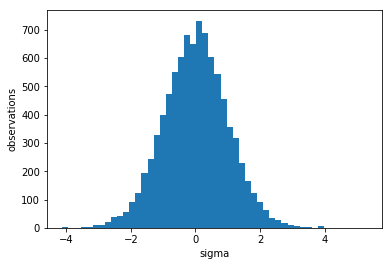

In [5]:
plt.hist(X, bins=50)
plt.xlabel('sigma')
plt.ylabel('observations')
plt.show()

In [6]:
# Sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X, X2])

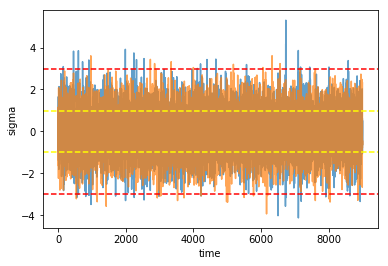

In [7]:
# Plot both the GARCH and normal values
plt.plot(both.T, alpha=.7);
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma')
plt.show()

What we're looking at here is the GARCH process in blue and the normal process in green. The 1 and 3 std bars are drawn on the plot. We can see that the blue GARCH process tends to cross the 3 std bar much more often than the green normal one.

## Testing for ARCH Behavior
The first step is to test for ARCH conditions. To do this we run a regression on $x_t$ fitting the following model.

$$x_t^2 = a_0 + a_1 x_{t-1}^2 + \dots + a_p x_{t-p}^2$$

We use OLS to estimate $\hat\theta = (\hat a_0, \hat a_1, \dots, \hat a_p)$ and the covariance matrix $\hat\Omega$. We can then compute the test statistic

$$F = \hat\theta \hat\Omega^{-1} \hat\theta'$$

We will reject if $F$ is greater than the 95% confidence bars in the $\mathcal(X)^2(p)$ distribution.

To test, we'll set $p=20$ and see what we get.

In [9]:
X, _ = simulate_GARCH(1100, a0, a1, b1, sigma1)
X = X[100:] # Drop burn in

p = 20

# Drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
X2 = np.ndarray((980, p))
for i in range(p, 1000):
    X2[i - p, :] = np.asarray((X**2)[i-p:i])[::-1]

model = sm.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = np.asscalar(theta * np.linalg.inv(omega) * theta.T)

print(np.asarray(theta.T).shape)

plt.plot(range(20), np.asarray(theta.T))
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

print('F = ' + str(F))

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print('p-value = ' + str(pvalue))

# Finally let's look at the significance of each a_p as measured by the standard deviations away from 0
print(theta/np.diag(omega))

(20, 1)
F = 415.04240485367853
p-value = 0.0
[[ 53.55053094  54.53029866  68.12315425  78.40705562   5.549719
   -8.46737952  49.25797149  19.30322987  52.70085066  43.90758715
   11.32539114 -50.41055982  30.88026553 -16.01094646  69.90106052
   69.52118162  38.73125475 -25.56441905  26.05043609  47.17162092]]


## Fitting GARCH(1, 1) with MLE
Once we've decided that the data might have an underlying GARCH(1, 1) model, we would like to fit GARCH(1, 1) to the data by estimating parameters.

To do this we need the log-likelihood function

$$\mathcal{L}(\theta) = \sum_{t=1}^T - \ln \sqrt{2\pi} - \frac{x_t^2}{2\sigma_t^2} - \frac{1}{2}\ln(\sigma_t^2)$$

To evaluate this function we need $x_t$ and $\sigma_t$ for $1 \leq t \leq T$. We have $x_t$, but we need to compute $\sigma_t$. To do this we need to make a guess for $\sigma_1$. Our guess will be $\sigma_1^2 = \hat E[x_t^2]$. Once we have our initial guess we compute the rest of the $\sigma$'s using the equation

$$\sigma_t^2 = a_0 + a_1 x_{t-1}^2 + b_1\sigma_{t-1}^2$$

In [10]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in

In [11]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

Let's look at the sigmas we just generated.

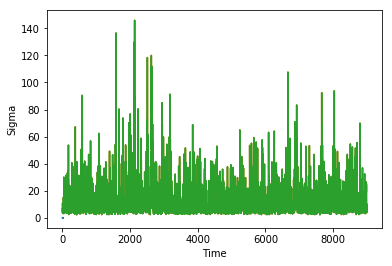

In [13]:
plt.plot(range(len(X)), compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma')
plt.show()

Now that we can compute the $\sigma_t$'s, we'll define the actual log likelihood function. This function will take as input our observations $x$ and $\theta$ and return $-\mathcal{L}(\theta)$. It is important to note that we return the negative log likelihood, as this way our numerical optimizer can minimize the function while maximizing the log likelihood.

Note that we are constantly re-computing the $\sigma_t$'s in this function.

In [14]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

Now we perform numerical optimization to find our estimate for
$$\hat\theta = \arg \max_{(a_0, a_1, b_1)}\mathcal{L}(\theta) = \arg \min_{(a_0, a_1, b_1)}-\mathcal{L}(\theta)$$

We have some constraints on this

$$a_1 \geq 0, b_1 \geq 0, a_1+b_1 < 1$$

In [15]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

C:\Users\liude\Anaconda3\envs\bt36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


theta MLE: [ 0.86764638  0.10756654  0.81002153]


Now we would like a way to check our estimate. We'll look at two things:

1. How fat are the tails of the residuals.
2. How normal are the residuals under the Jarque-Bera normality test.

We'll do both in our `check_theta_estimate` function.

In [16]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print('Tails table')
    print(compare_tails_to_normal(epsilon / np.std(epsilon)))
    print('')
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print('Jarque-Bera probability normal: ' + str(pvalue))
    
check_theta_estimate(X, theta_mle)

Tails table
[[  1.56333333e-01   2.27777778e-02   8.88888889e-04   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.546690037655


## GMM for Estimating GARCH(1, 1) Parameters
We've just computed an estimate using MLE, but we can also use Generalized Method of Moments (GMM) to estimate the GARCH(1, 1) parameters.

To do this we need to define our moments. We'll use 4.

1. The residual $\hat\epsilon_t = x_t / \hat\sigma_t$
2. The variance of the residual $\hat\epsilon_t^2$
3. The skew moment $\mu_3/\hat\sigma_t^3 = (\hat\epsilon_t - E[\hat\epsilon_t])^3 / \hat\sigma_t^3$
4. The kurtosis moment $\mu_4/\hat\sigma_t^4 = (\hat\epsilon_t - E[\hat\epsilon_t])^4 / \hat\sigma_t^4$

In [17]:
# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

GMM now has three steps.

Start with $W$ as the identity matrix.

1. Estimate $\hat\theta_1$ by using numerical optimization to minimize

$$\min_{\theta \in \Theta} \left(\frac{1}{T} \sum_{t=1}^T g(x_t, \hat\theta)\right)' W \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta)\right)$$

2. Recompute $W$ based on the covariances of the estimated $\theta$. (Focus more on parameters with explanatory power)

$$\hat W_{i+1} = \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta_i)g(x_t, \hat\theta_i)'\right)^{-1}$$

3. Repeat until $|\hat\theta_{i+1} - \hat\theta_i| < \epsilon$ or we reach an iteration threshold.

Initialize $W$ and $T$ and define the objective function we need to minimize.

In [18]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

Now we're ready to the do the iterated minimization step.

In [19]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print('Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate))
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))
    

check_theta_estimate(X, theta_gmm_estimate)

Iteration 0 theta: [ 0.86764093  0.1075364   0.80997948]
Iteration 1 theta: [ 0.86779701  0.10792822  0.81055575]
Iteration 2 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 3 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 4 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 5 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 6 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 7 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 8 theta: [ 0.86779468  0.1079089   0.81053272]
Iteration 9 theta: [ 0.86779468  0.1079089   0.81053272]
Tails table
[[  1.56333333e-01   2.27777778e-02   8.88888889e-04   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.546350208258


## Predicting the Future: How to actually use what we've done
Now that we've fitted a model to our observations, we'd like to be able to predict what the future volatility will look like. To do this, we can just simulate more values using our original GARCH dynamics and the estimated parameters.

The first thing we'll do is compute an initial $\sigma_t$. We'll compute our squared sigmas and take the last one.

In [20]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

2.9403128403953067

Now we'll just sample values walking forward.

In [21]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

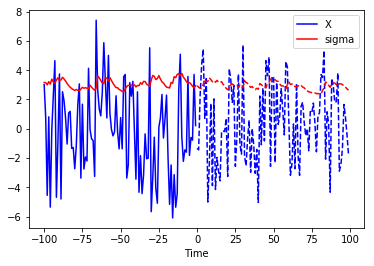

In [22]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])
plt.show()

One should note that because we are moving foward using a random walk, this analysis is supposed to give us a sense of the magnitude of sigma and therefore the risk we could face. It is not supposed to accurately model future values of X. In practice you would probably want to use Monte Carlo sampling to generate thousands of future scenarios, and then look at the potential range of outputs. We'll try that now. Keep in mind that this is a fairly simplistic way of doing this analysis, and that better techniques, such as Bayesian cones, exist.

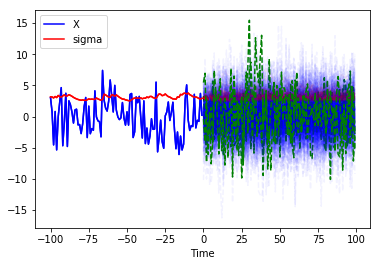

In [24]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])


max_X = [-np.inf]
min_X = [np.inf]
for i in range(100):
    X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
    if max(X_forecast) > max(max_X):
        max_X = X_forecast
    elif min(X_forecast) < min(max_X):
        min_X = X_forecast
    plt.plot(range(0, 100), X_forecast, 'b--', alpha=0.05)
    plt.plot(range(0, 100), sigma_forecast, 'r--', alpha=0.05)

# Draw the most extreme X values specially
plt.plot(range(0, 100), max_X, 'g--', alpha=1.0)
plt.plot(range(0, 100), min_X, 'g--', alpha=1.0)
plt.show()

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*